In [1]:

import nest_asyncio
nest_asyncio.apply()

import autogen
import json
import pandas as pd
import concurrent.futures
from datetime import datetime
from typing import Union, List, Dict
import guidance
from pydantic import BaseModel

In [2]:
questions = [
"""
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.
""",
"""
Create a comparative analysis of machine learning models used for predicting glass transition temperature (Tg) and melting temperature (Tm) of polymers. Include the following in your analysis:

A table comparing at least 5 different models, with the following information for each:
a) Model name and type (e.g., Random Forest, Neural Network, etc.)
b) Year introduced
c) Key authors/research group
d) Input features or representation used
e) Dataset size and composition
f) Accuracy metrics for Tg prediction (e.g., R², RMSE, MAE)
g) Accuracy metrics for Tm prediction (e.g., R², RMSE, MAE)
h) Computational complexity or training time (if available)
A brief discussion (2-3 paragraphs) on:
a) The overall trends in prediction accuracy for Tg vs Tm
b) Factors that contribute to higher accuracy in certain models
c) Challenges in predicting these properties accurately
d) Recent advancements or novel approaches in the field
A short section on potential areas for improvement and future research directions.

Please provide citations for the models and studies mentioned in your analysis.
"""
]

models = ['gpt-4', 'gpt-4o', 'gpt-4o-mini', 'gpt-35-turbo', 'gpt-35-turbo-16k']

# input_dir = '/home/azureuser/autogen_uscases/graphrag_memo/output/20240830-145930/artifacts'
input_dir = '/home/azureuser/autogen_uscases/autosearch/notebooks/graphrag/output/20240903-050706/artifacts'
# input_dir = '/home/azureuser/autogen_uscases/graphrag_memo/output/20240830-145930/artifacts'
lancedb_uri = "/home/azureuser/autogen_uscases/autosearch/notebooks/graphrag/output/20240903-050706/artifacts/lancedb"
embedding_model = 'text-embedding-3-small'

results_json = 'results_20240903_094137.json'
results = pd.read_json(results_json)


In [3]:


class EvaluationScores(BaseModel):
    relevance: Dict[str, float]
    completeness: Dict[str, float]
    accuracy: Dict[str, float]
    clarity: Dict[str, float]
    unique_insights: Dict[str, float]
    coherence: Dict[str, float]
    source_diversity: Dict[str, float]
    overall: Dict[str, float]

class EvaluationResult(BaseModel):
    scores: EvaluationScores
    explanation: str

In [4]:
config_list = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST-sweden-505",
    file_location=".",
    filter_dict={
        "model": ["gpt-4"]
    },
)

llm_config = {
    "config_list": config_list,
    "timeout": 120,
}

# Create the GPT-4 agent
gpt4_agent = autogen.AssistantAgent(
    name="gpt4_evaluator",
    llm_config=llm_config
)

# Create a user proxy agent
user_proxy = autogen.UserProxyAgent(
    name="user_proxy",
    human_input_mode="NEVER",
    max_consecutive_auto_reply=10,
    is_termination_msg=lambda x: x.get("content", "").rstrip().endswith("TERMINATE"),
    code_execution_config=False,
)

In [5]:
def create_evaluation_prompt(result: Dict) -> str:
    prompt = f"""
    Evaluate and compare the following search results for the question: "{result['question']}"
    
    Model used: {result['model']}
    
    Local search result:
    {result['local_result']}
    
    Global search result:
    {result['global_result']}
    
    Please provide a detailed evaluation considering the following criteria:
    1. Relevance: How well does each result address the question?
    2. Completeness: Which result provides more comprehensive information?
    3. Accuracy: Are there any apparent errors or inconsistencies in either result?
    4. Clarity: Which result is easier to understand?
    5. Unique insights: Does either result provide unique information not present in the other?
    6. Coherence: How well-structured and logically connected is the information in each result?
    7. Source diversity: Does the result appear to draw from a variety of sources or perspectives?
    
    For each criterion, provide a brief explanation of your reasoning, followed by a score for both Local and Global results on a scale of 1-10.
    
    After your analysis, provide an overall score for each result, taking into account all the above criteria.
    
    Finally, conclude with a brief statement on which result (Local or Global) you think is better for this particular question and why.
    
    Your response MUST be a valid JSON object with the following structure:
    {{
        "explanation": "Your detailed evaluation and conclusion here",
        "scores": {{
            "relevance": {{"local": float, "global": float}},
            "completeness": {{"local": float, "global": float}},
            "accuracy": {{"local": float, "global": float}},
            "clarity": {{"local": float, "global": float}},
            "unique_insights": {{"local": float, "global": float}},
            "coherence": {{"local": float, "global": float}},
            "source_diversity": {{"local": float, "global": float}},
            "overall": {{"local": float, "global": float}}
        }}
    }}

    Ensure all scores are between 1 and 10, and that the JSON is properly formatted.
    """
    return prompt

In [6]:


def generate_structured_evaluation(recipient, messages, sender, config):
    gpt =  guidance.models.AzureOpenAI(
        model=config_list[0]["model"],
        azure_endpoint=config_list[0]["base_url"],
        azure_deployment=config_list[0]["model"],
        version=config_list[0]["api_version"],
        api_key=config_list[0]["api_key"],
    )

    # Populate the recipient with the messages from the history
    with guidance.system():
        lm = gpt + recipient.system_message

    for message in messages:
        if message.get("role") == "user":
            with guidance.user():
                lm += message.get("content")
        else:
            with guidance.assistant():
                lm += message.get("content")

    max_attempts = 3
    for attempt in range(max_attempts):
        # Generate a new response and store it
        with guidance.assistant():
            lm += guidance.gen(name="evaluation_json")

        # Extract the JSON part from the response
        response = lm["evaluation_json"]
        json_start = response.find('{')
        json_end = response.rfind('}') + 1
        if json_start != -1 and json_end != -1:
            json_str = response[json_start:json_end]

            # Validate and parse the JSON response
            try:
                json_obj = json.loads(json_str)
                evaluation_result = EvaluationResult.model_validate(json_obj)
                return True, evaluation_result.model_dump_json()
            except json.JSONDecodeError as e:
                if attempt < max_attempts - 1:
                    with guidance.user():
                        lm += f"The response was not a valid JSON. Please try again and ensure your entire response is a valid JSON object. Error: {str(e)}"
                else:
                    return False, f"Error parsing evaluation result after {max_attempts} attempts: {str(e)}"
            except Exception as e:
                if attempt < max_attempts - 1:
                    with guidance.user():
                        lm += f"The JSON was not in the correct format. Please try again and ensure your response matches the required structure. Error: {str(e)}"
                else:
                    return False, f"Error validating evaluation result after {max_attempts} attempts: {str(e)}"
        else:
            if attempt < max_attempts - 1:
                with guidance.user():
                    lm += "The response did not contain a valid JSON object. Please try again and ensure your entire response is a valid JSON object."
            else:
                return False, f"Error: No valid JSON object found in the response after {max_attempts} attempts."

    return False, f"Failed to generate a valid evaluation result after {max_attempts} attempts."

In [7]:
def evaluate_single_result(result: Dict) -> Dict:
    print("=============================================")
    print(f"Evaluating question: {result['question']}, model: {result['model']}")
    print("=============================================")
    prompt = create_evaluation_prompt(result)
    
    guidance_agent = autogen.AssistantAgent("guidance_labeler",
                                            llm_config=llm_config, 
                                            system_message="You are a helpful assistant",
                                            
                                            )
    guidance_agent.register_reply(autogen.Agent, generate_structured_evaluation, 1)
    user_proxy = autogen.UserProxyAgent("user", 
                                        human_input_mode="NEVER", 
                                        code_execution_config=False,
                                        max_consecutive_auto_reply=1,
                                        )
    user_proxy.initiate_chat(
        guidance_agent,
        message=prompt,
    )
    
    evaluation = user_proxy.last_message()["content"]
    
    try:
        evaluation_result = EvaluationResult.model_validate_json(evaluation)
        return {
            "question": result["question"],
            "model": result["model"],
            "local_result": result["local_result"],
            "global_result": result["global_result"],
            "prompt": prompt,
            "evaluation": evaluation_result.explanation,
            "scores": evaluation_result.scores.model_dump()
        }
    except Exception as e:
        print(f"Error parsing evaluation result: {str(e)}")
        return {
            "question": result["question"],
            "model": result["model"],
            "local_result": result["local_result"],
            "global_result": result["global_result"],
            "prompt": prompt,
            "evaluation": "Error parsing evaluation",
            "scores": {}
        }

In [8]:
def evaluate_results(results: Union[List[Dict], pd.DataFrame]) -> pd.DataFrame:
    evaluations = []
    
    def evaluate_and_store(result: Dict) -> None:
        evaluation = evaluate_single_result(result)
        evaluations.append(evaluation)
    
    # Convert to DataFrame if it's a list
    if isinstance(results, list):
        results_df = pd.DataFrame(results)
    else:
        results_df = results
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
        futures = [executor.submit(evaluate_and_store, row.to_dict()) for _, row in results_df.iterrows()]
        concurrent.futures.wait(futures)
    
    # Convert evaluations to DataFrame
    eval_df = pd.DataFrame(evaluations)
    
    # Expand the scores dictionary into separate columns
    score_df = pd.json_normalize(eval_df['scores'])
    score_df.columns = [f'score_{col}' for col in score_df.columns]
    
    # Combine the evaluation DataFrame with the scores DataFrame
    eval_df = pd.concat([eval_df.drop(columns=['scores']), score_df], axis=1)
    
    return eval_df

In [9]:
# Run the evaluation
evaluations_df = evaluate_results(results)

# Generate a unique filename with timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# If you still want to save as JSON
json_filename = f'evaluations_{timestamp}.json'
evaluations_df.to_json(json_filename, orient='records', indent=4)
print(f"Evaluations also saved as JSON to {json_filename}")

guidance_labeler (to user):

{"scores":{"relevance":{"local":9.5,"global":1.0},"completeness":{"local":9.0,"global":1.0},"accuracy":{"local":9.0,"global":1.0},"clarity":{"local":9.0,"global":1.0},"unique_insights":{"local":8.5,"global":1.0},"coherence":{"local":9.0,"global":1.0},"source_diversity":{"local":8.0,"global":1.0},"overall":{"local":9.0,"global":1.0}},"explanation":"The Local search result provides a comprehensive and relevant response to the question, including a table comparing different machine learning models and a discussion on trends, factors, challenges, and potential areas for improvement in predicting Tg and Tm of polymers. It also cites sources for the models mentioned. The Global search result, however, does not provide any information and simply states an inability to answer the question. Therefore, the Local search result scores highly on relevance, completeness, accuracy, clarity, coherence, and source diversity. The Global search result, due to its lack of cont

NameError: name 'filename' is not defined

/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


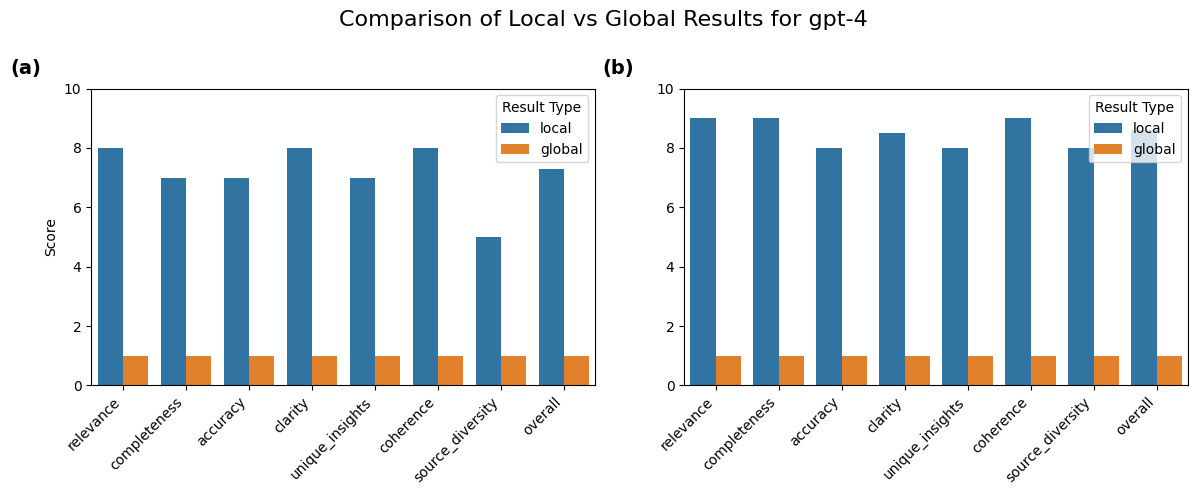

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

Explanation: The Local result provides a synthesized table with relevant information about different polymer representation models, addressing the question directly and offering a comparison based on the requested criteria. Although it lacks specific details s

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
from termcolor import colored

def display_comparison(evaluations_df, model):
    # Filter for the specified model
    model_df = evaluations_df[evaluations_df.model == model].copy()

    # Melt the dataframe to create a long format suitable for plotting
    melted_df = pd.melt(model_df, 
                        id_vars=['question'], 
                        value_vars=[col for col in model_df.columns if col.startswith('score_')],
                        var_name='criterion', 
                        value_name='score')

    # Extract local/global info and clean up criterion names
    melted_df['type'] = melted_df['criterion'].str.split('.').str[-1]
    melted_df['criterion'] = melted_df['criterion'].str.replace('score_', '').str.split('.').str[0]

    # Get number of questions
    n_questions = len(model_df['question'].unique())

    # Calculate grid dimensions
    n_cols = min(3, n_questions)  # Max 3 columns
    n_rows = (n_questions - 1) // n_cols + 1

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows), squeeze=False)
    fig.suptitle(f"Comparison of Local vs Global Results for {model}", fontsize=16)

    # Flatten the axes array for easier iteration
    axes_flat = axes.flatten()

    for idx, (question, ax) in enumerate(zip(model_df['question'].unique(), axes_flat)):
        question_df = melted_df[melted_df['question'] == question]
        
        sns.barplot(x='criterion', y='score', hue='type', data=question_df, ax=ax)
        ax.set_ylim(0, 10)  # Assuming scores are from 0 to 10
        ax.set_xlabel('')
        ax.set_ylabel('Score' if idx % n_cols == 0 else '')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        ax.legend(title='Result Type')
        
        # Add subplot label (a, b, c, ...)
        ax.text(-0.1, 1.1, f"({string.ascii_lowercase[idx]})", transform=ax.transAxes, 
                fontsize=14, fontweight='bold', va='top', ha='right')

    # Remove any unused subplots
    for ax in axes_flat[n_questions:]:
        ax.remove()

    plt.tight_layout()
    plt.show()

    # Print questions, explanations, and evaluations with colored and bold labels
    for idx, (_, row) in enumerate(model_df.iterrows()):
        print(f"({string.ascii_lowercase[idx]}) {colored('Question:', 'red', attrs=['bold'])} {row['question']}")
        print(f"{colored('Explanation:', 'red', attrs=['bold'])} {row['evaluation']}")
        print(f"{colored('Local Result:', 'red', attrs=['bold'])} {row['local_result']}")
        print(f"{colored('Global Result:', 'red', attrs=['bold'])} {row['global_result']}")
        print("\n" + "="*50 + "\n")

# Usage
display_comparison(evaluations_df, 'gpt-4')

/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


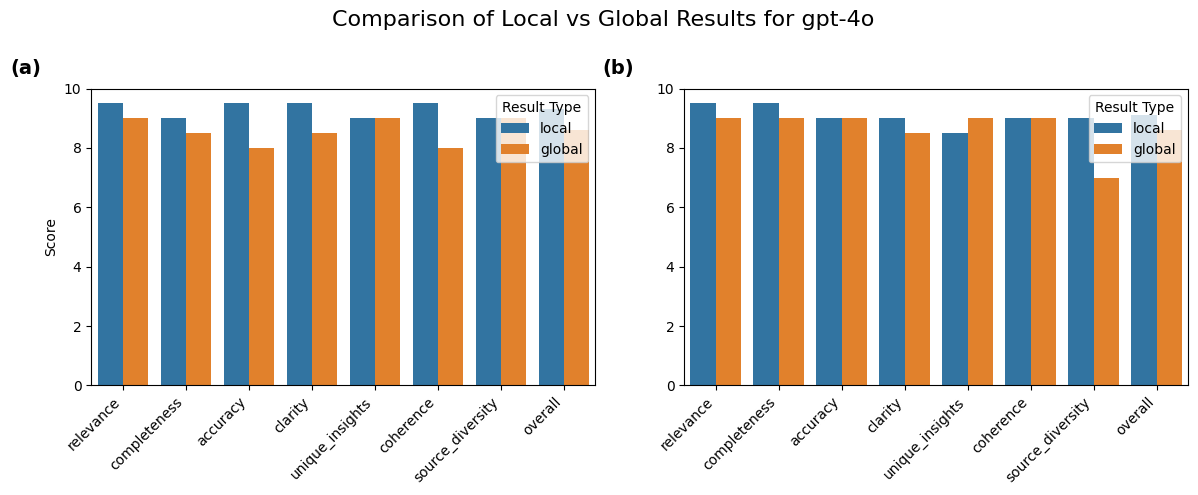

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

Explanation: Both the Local and Global search results provide a comprehensive table comparing representation learning models for polymers, which is directly relevant to the question. The Local result is more specific with years, authors, and other details, whi

In [12]:
display_comparison(evaluations_df, 'gpt-4o')

/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


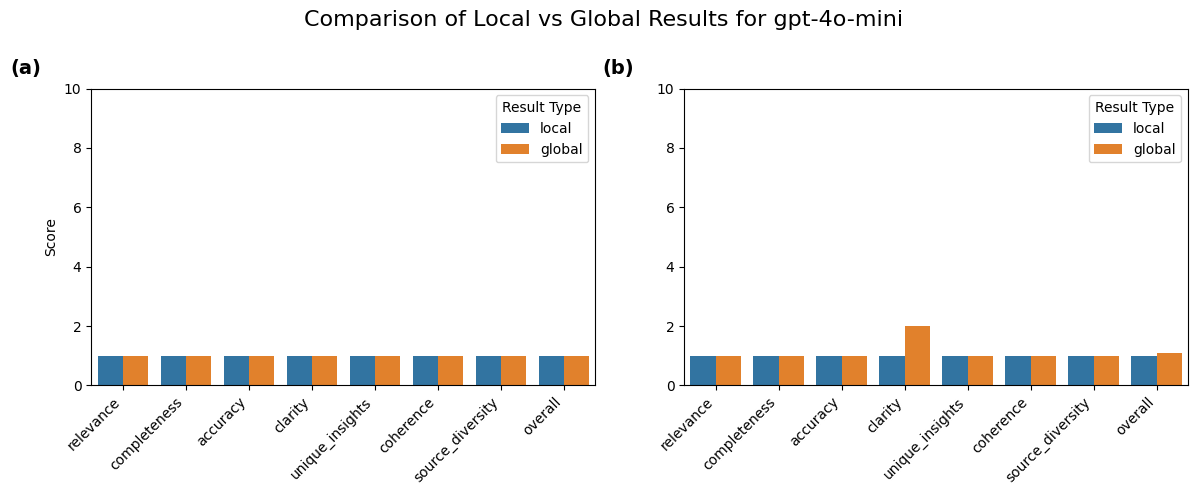

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

Explanation: The evaluation of the search results for the question on creating a comprehensive table comparing representation learning models for polymers indicates that neither the Local nor the Global search result provided the requested information. Both re

In [13]:
display_comparison(evaluations_df, 'gpt-4o-mini')

/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


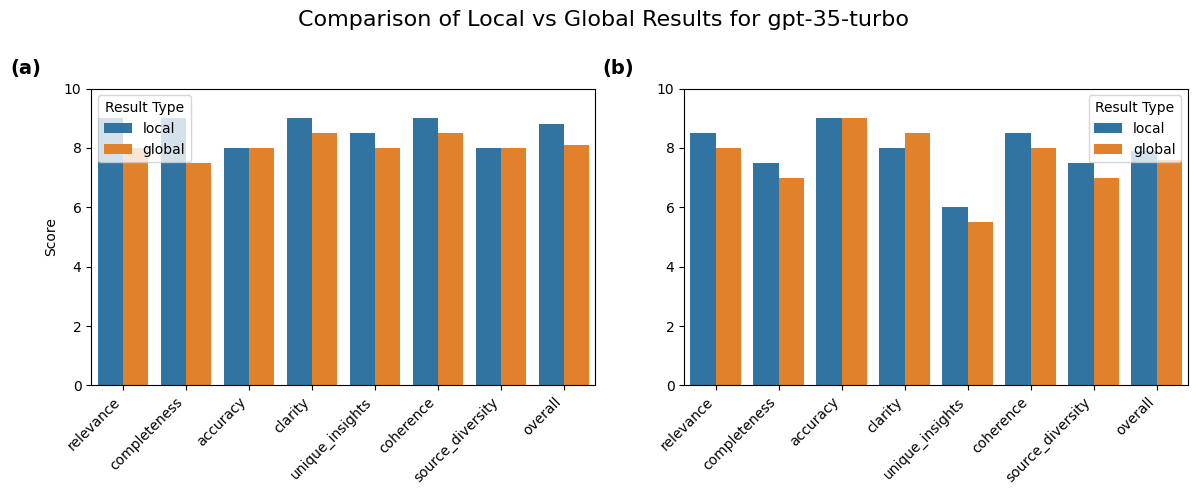

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

Explanation: Both the Local and Global search results provide relevant information addressing the question of comparing representation learning models for polymers. The Local result includes specific models like TransPolymer, PolyBERT, and MPNN, while the Glob

In [14]:
display_comparison(evaluations_df, 'gpt-35-turbo')

/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_1128574/3778085323.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


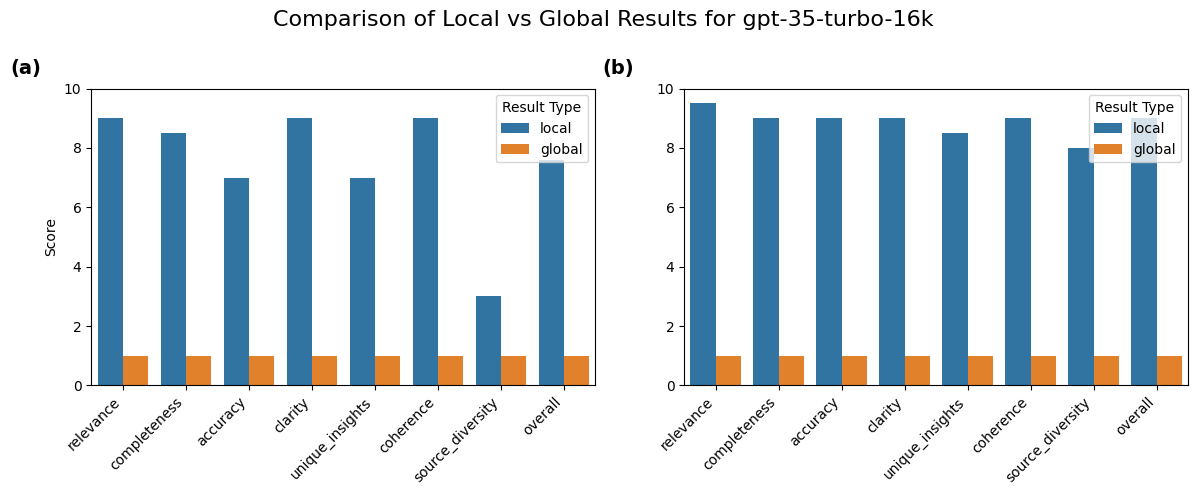

(a) Question: 
Create a comprehensive table comparing representation learning models for polymers. Include the following information for each model:

Model name
Year introduced
Key authors/research group
Type of representation (e.g., graph-based, sequence-based, 3D structure-based)
Input features used
Dimensionality of the learned representation
Training data type and size
Key applications (e.g., property prediction, polymer design)
Notable advantages
Limitations or challenges

After the table, provide a brief analysis (2-3 paragraphs) of the current trends in polymer representation learning, highlighting the most promising approaches and areas for future research. Please cite relevant papers for each model and in your analysis.

Explanation: The Local search result provides a comprehensive table with specific models, their characteristics, and a brief analysis of current trends in polymer representation learning. It addresses the question directly by listing the required information f

In [15]:
display_comparison(evaluations_df, 'gpt-35-turbo-16k')